# 多输入多输出通道

当我们添加通道时，输入和隐藏的表示都变成了三维张量。例如，每个RGB输入图像具有 $3 \times h \times w$ 的形状。我们将这个大小为3的轴称为通道维度。本届深入探究具有多个输入和输出通道的卷积核。

## 多输入通道

当输入包含多个通道的时候，需要构造一个与输入数据具有相同输入通道数的卷积核，一遍与输入数据进行互相关计算。假设输入的通道数为 $c_i$，那么卷积核的输入通道数也需要为 $c_i$。如果卷积核的窗口形状是 $k_h \times k_w$, 那么当$c_i = 1$时，我们可以吧卷积核看做形状为 $k_h \times k_w$ 的二位张量。

若$c_i > 1$, 看如下示例：

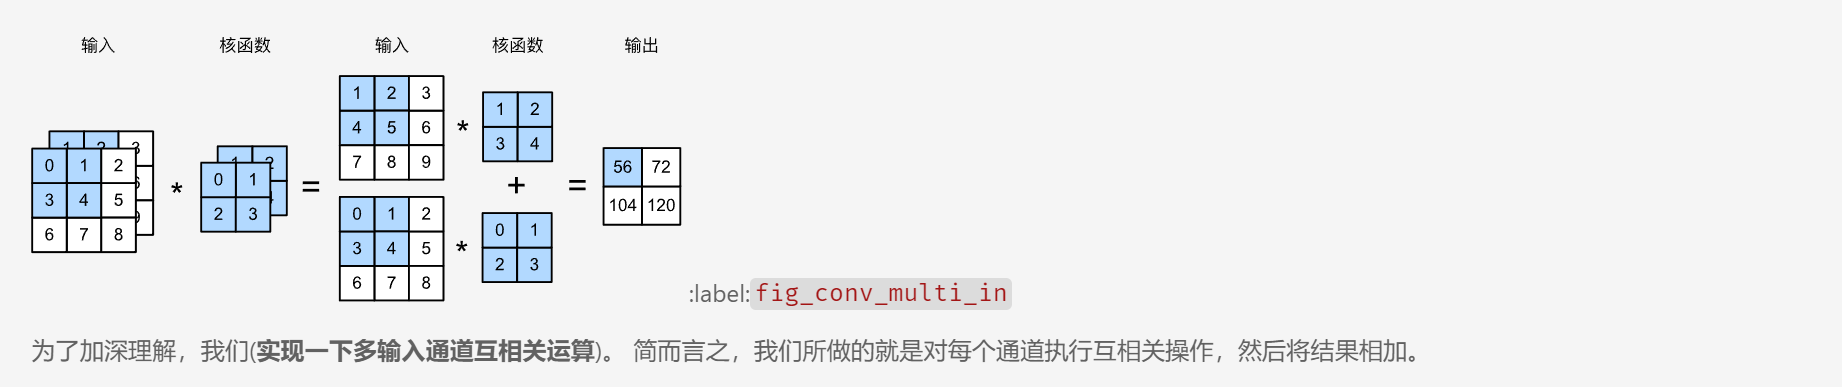



In [1]:
import torch
from d2l import torch as d2l

In [2]:
def corr2d_multi_in(X, K):
    # 先遍历"X"和“K”的第0维度（通道维度），再把他们加到一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

构造与上述例子相同的对应的输入张量`X`和核张量`K`，以 **[验证互相关运算的输出]**。

In [3]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])

K =  torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 多个输出通道
有时候，每一层有多个输出通道是至关重要的。在最流行的神经网络架构中，随着神经网络层数的加深，常常会加深输出通道的维数，通过减少空间分辨率以获得更大的通道深度。直观地说，我们可以将每个通道看作对不同特征的响应。而现实可能更为复杂，因为每个通道不是独立学习的，而是为了共同使用而优化的。因此，多个输出通道并不仅是学习多个单通道的检测器。

用 $c_i$ 和 $c_o$ 分别表示输入和输出通道的数目，并让 $k_h$ 和 $k_w$ 为卷积核的高度和宽度。为了获得多个通道的输出，我们可以为每个通道创建一个形状为 $c_i \times k_h \times k_w$ 的卷积核张量，这样的卷积核形状是 $c_o \times c_i \times k_h \times k_w$。在互相关计算中，每个输出通道先获取所有的输入通道，再以对应该输出通道的卷积核计算结果。

如下所示，实现一个**计算多个通道的输出的互相关函数**。

In [4]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

通过将核张量`K`与`K+1`（`K`中每个元素加1）和`K+2`连接起来，构造了一个具有3个输出通道的卷积核。

In [5]:
K = torch.stack((K, K+1, K+2), 0)
K.shape

torch.Size([3, 2, 2, 2])

下面，对输入张量`X`与卷积核张量`K`执行互相关运算。现在的输出包含3个通道，第一个通道的结果与先前输入张量`X`和多输入单输出通道的结果一致。

In [6]:
print("K的形状：", K.shape)

K的形状： torch.Size([3, 2, 2, 2])


In [7]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## $1 \times 1$ 卷积层
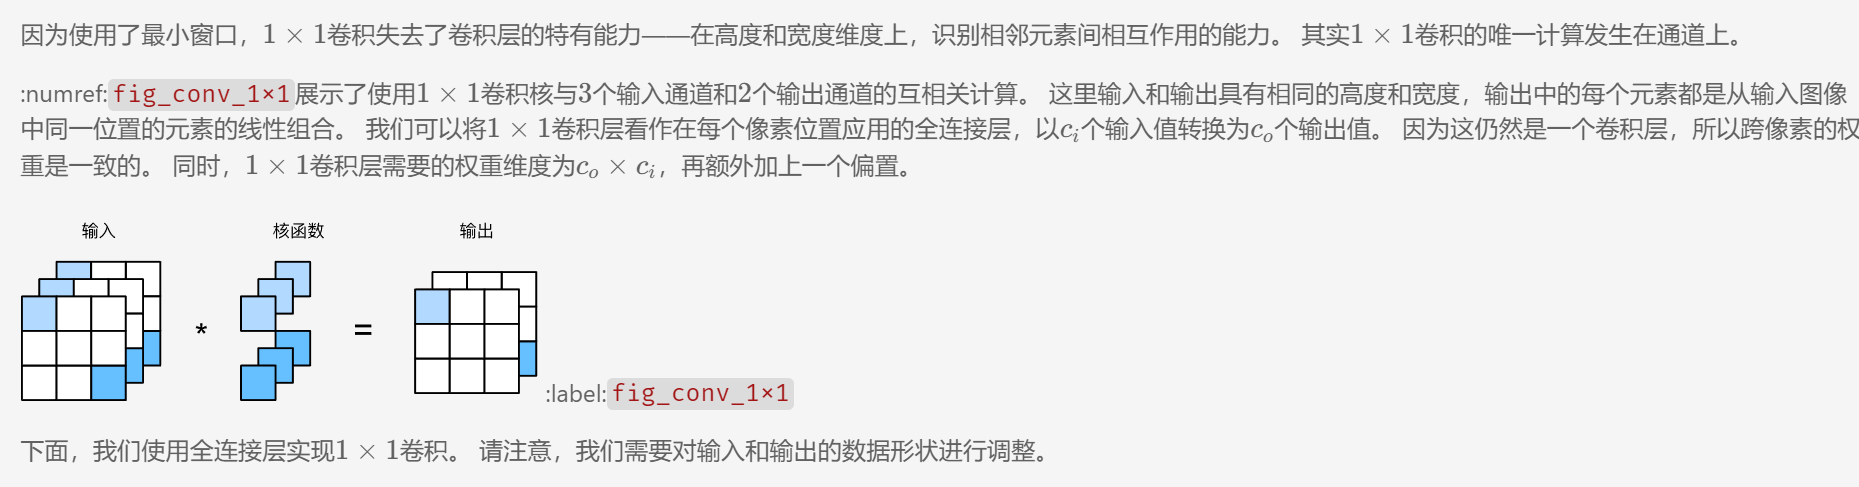

In [8]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

当执行$1 \times 1$卷积运算时，上述函数相当于先前实现的互相关函数`corr2d_multi_out`。

In [9]:
X = torch.normal(0, 1, (3,3,3))

K = torch.normal(0, 1, (2, 3, 1, 1))

In [12]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6